# Quantium Virtual Internship - Retail Strategy and Analytics 

# Load Required Libraries and Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
from datetime import datetime, timedelta
from scipy.stats import ttest_ind
from collections import Counter

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load datasets
transaction_data = pd.read_excel(r"C:\Users\SARTMAN\Documents\Data Science\Tableau\Forage\Quantum\QVI_transaction_data.xlsx")
customer_data = pd.read_csv(r"C:\Users\SARTMAN\Documents\Data Science\Tableau\Forage\Quantum\QVI_purchase_behaviour.csv")

# Exploratory Data Analysis: Transactions

In [3]:
print("Transactions Data Info:")
print(transaction_data.info())
print(transaction_data.head())

# Convert DATE column from integer to datetime format (origin: 1899-12-30)
if np.issubdtype(transaction_data['DATE'].dtype, np.number):
    transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], unit='D', origin='1899-12-30')
print("\nConverted DATE Column Sample:")
print(transaction_data['DATE'].head())

# Examine product names (PROD_NAME)
unique_products = transaction_data['PROD_NAME'].unique()
print("\nUnique Product Names:")
print(unique_products)

# Basic text analysis: Split product names into words and count common terms
all_words = " ".join(unique_products)
words_list = re.findall(r'\b[A-Za-z]+\b', all_words.lower())
word_counts = Counter(words_list)
print("\nTop 10 Most Common Words in PROD_NAME:")
print(word_counts.most_common(10))


Transactions Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB
None
    DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0  43390          1            1000       1         5   
1  43599          1            1307     348        66   
2  43605          1            1343     383        61   
3  43329          2            2373     974        69   
4  43330          2            2426    1038       108

# Data Cleaning & Outlier Handling: Transactions
 1. We will be dropping rows that contain salsa because we need to focus solely on chips/crisps and not dips (as in salsa)
 2. The obvious outlier in the quantity column is the entries for 200 units in a transaction

In [4]:
# Remove entries containing "salsa" (case insensitive)
transaction_data = transaction_data[~transaction_data['PROD_NAME'].str.contains("salsa", case=False, na=False)]
print("\nTransactions shape after removing salsa products:", transaction_data.shape)

# Display summary statistics
print("\nTransactions Summary Statistics:")
print(transaction_data.describe())

# Investigate outliers in PROD_QTY (200 units in a transaction)
if 'PROD_QTY' in transaction_data.columns:
    outliers = transaction_data[transaction_data['PROD_QTY'] == 200]
    print("\nTransactions with PROD_QTY == 200:")
    print(outliers)
    # Remove outlier customers (e.g., if a customer only appears with bulk orders)
    outlier_customers = outliers['LYLTY_CARD_NBR'].unique()
    print("\nOutlier Customer(s) based on PROD_QTY:", outlier_customers)
    transaction_data = transaction_data[~transaction_data['LYLTY_CARD_NBR'].isin(outlier_customers)]
    print("Transactions shape after removing outlier customers:", transaction_data.shape)


Transactions shape after removing salsa products: (246742, 8)

Transactions Summary Statistics:
           STORE_NBR  LYLTY_CARD_NBR        TXN_ID       PROD_NBR  \
count  246742.000000    2.467420e+05  2.467420e+05  246742.000000   
mean      135.051098    1.355310e+05  1.351311e+05      56.351789   
std        76.787096    8.071528e+04  7.814772e+04      33.695428   
min         1.000000    1.000000e+03  1.000000e+00       1.000000   
25%        70.000000    7.001500e+04  6.756925e+04      26.000000   
50%       130.000000    1.303670e+05  1.351830e+05      53.000000   
75%       203.000000    2.030840e+05  2.026538e+05      87.000000   
max       272.000000    2.373711e+06  2.415841e+06     114.000000   

            PROD_QTY      TOT_SALES  
count  246742.000000  246742.000000  
mean        1.908062       7.321322  
std         0.659831       3.077828  
min         1.000000       1.700000  
25%         2.000000       5.800000  
50%         2.000000       7.400000  
75%         2.0

# Time Series Analysis: Transactions Over Time


Transactions by Day (sample):
        DATE    N
0 2018-07-01  663
1 2018-07-02  650
2 2018-07-03  674
3 2018-07-04  669
4 2018-07-05  660


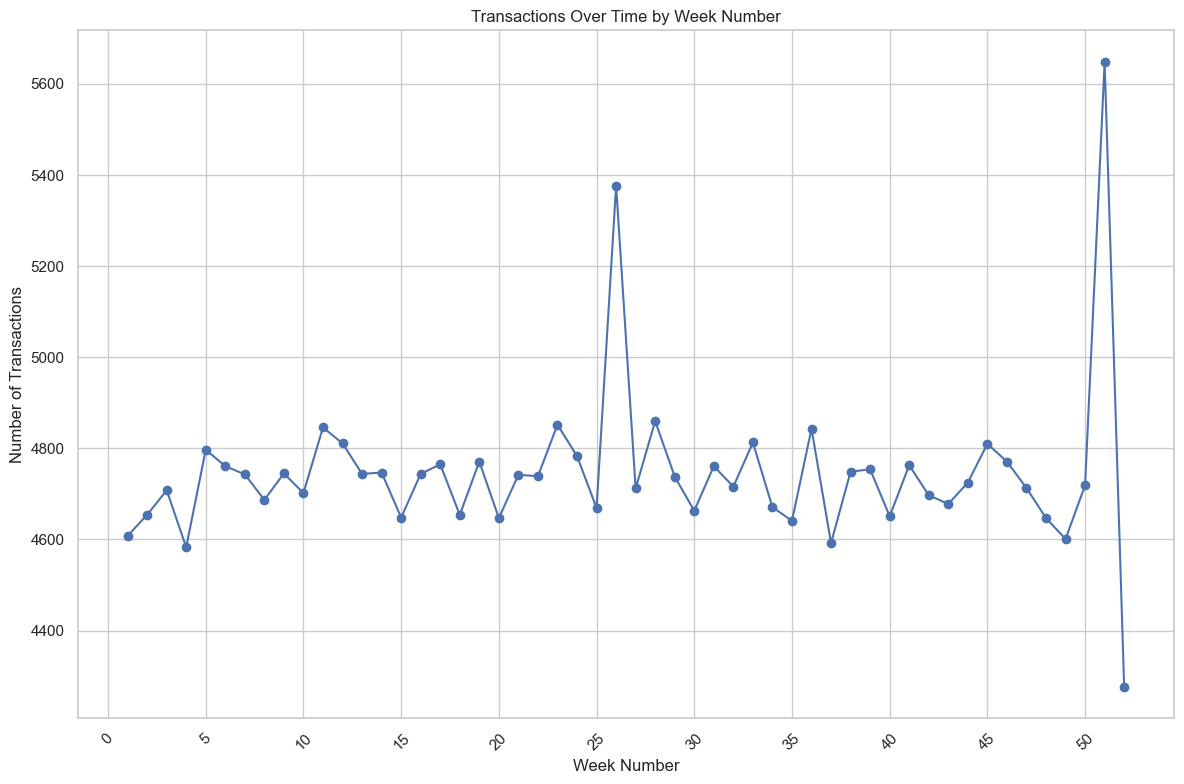

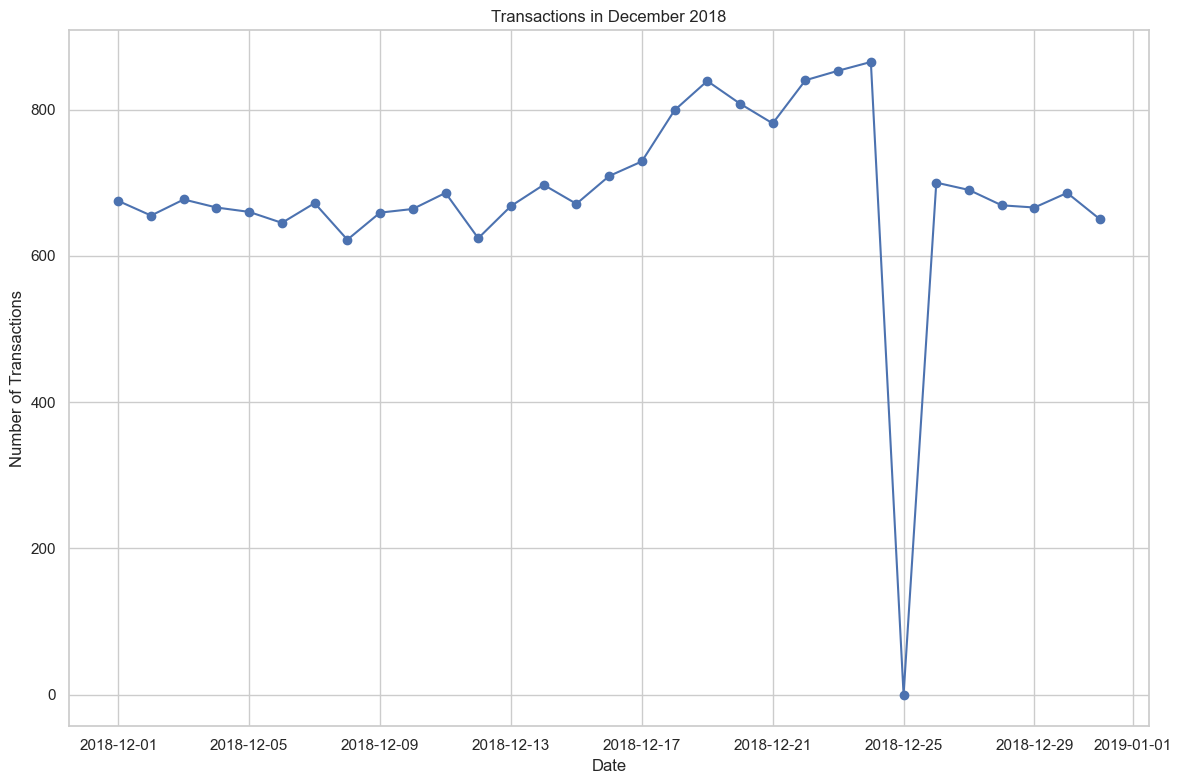

In [5]:
# Count transactions per date
transactions_by_day = transaction_data.groupby('DATE').size().reset_index(name='N')
print("\nTransactions by Day (sample):")
print(transactions_by_day.head())

# Create a full date range (1 Jul 2018 to 30 Jun 2019)
start_date = pd.to_datetime("2018-07-01")
end_date = pd.to_datetime("2019-06-30")
all_dates = pd.DataFrame({'DATE': pd.date_range(start_date, end_date)})
transactions_by_day = pd.merge(all_dates, transactions_by_day, on='DATE', how='left')
transactions_by_day['N'] = transactions_by_day['N'].fillna(0)
# Add a week number column to the transactions data
transactions_by_day['WEEK_NUMBER'] = transactions_by_day['DATE'].dt.isocalendar().week

# Group transactions by week number
transactions_by_week = transactions_by_day.groupby('WEEK_NUMBER')['N'].sum().reset_index()

# Plot transactions over time by week
plt.figure()
plt.plot(transactions_by_week['WEEK_NUMBER'], transactions_by_week['N'], marker='o', linestyle='-')
plt.xlabel("Week Number")
plt.ylabel("Number of Transactions")
plt.title("Transactions Over Time by Week Number")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("transactions_by_week.png")
plt.show()
plt.close()

# Zoom in on December 2018
december_mask = (transactions_by_day['DATE'] >= '2018-12-01') & (transactions_by_day['DATE'] <= '2018-12-31')
transactions_december = transactions_by_day[december_mask]
plt.figure()
plt.plot(transactions_december['DATE'], transactions_december['N'], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.title("Transactions in December 2018")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("transactions_december.png")
plt.show()
plt.close()

# Feature Engineering: Pack Size and Brand Extraction


Pack Size Summary:
count    246740.000000
mean        175.583521
std          59.432118
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: PACK_SIZE, dtype: float64


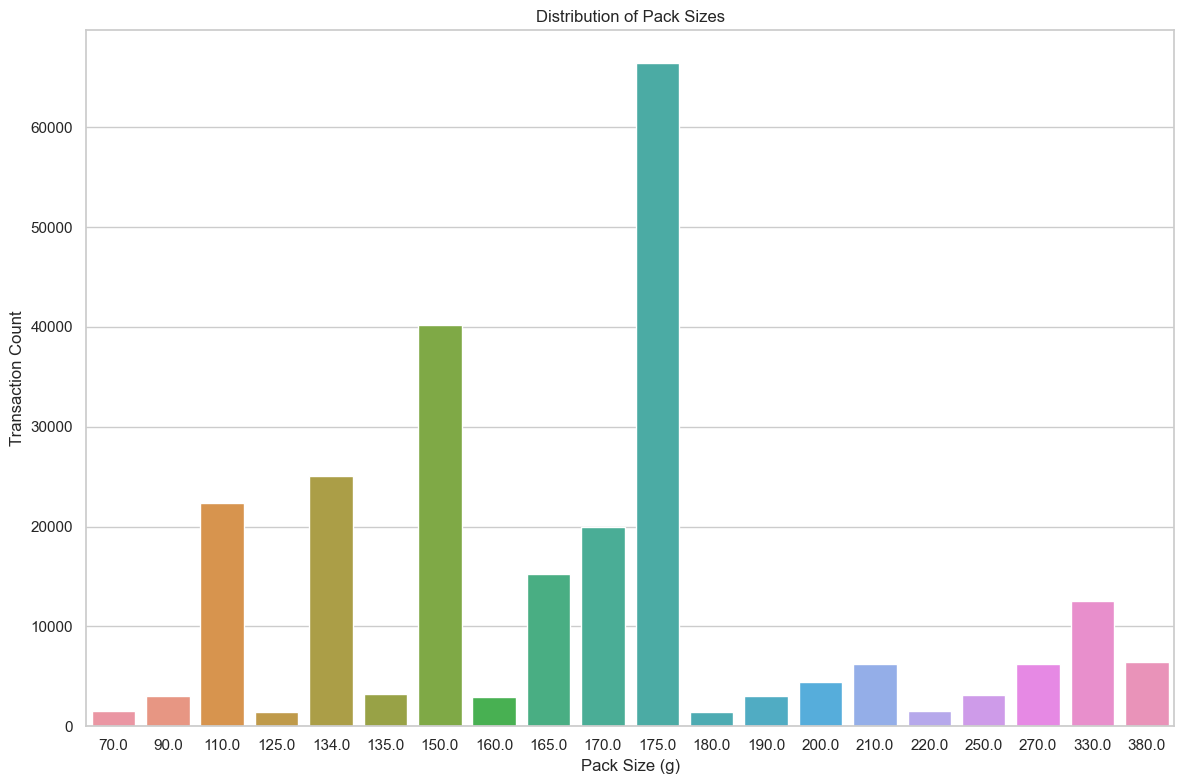


Unique Brand Names Before Cleaning:
['NATURAL' 'CCS' 'SMITHS' 'KETTLE' 'GRAIN' 'DORITOS' 'TWISTIES' 'WW'
 'THINS' 'BURGER' 'NCC' 'CHEEZELS' 'INFZNS' 'RED' 'PRINGLES' 'DORITO'
 'INFUZIONS' 'SMITH' 'GRNWVES' 'TYRRELLS' 'COBS' 'FRENCH' 'RRD' 'TOSTITOS'
 'CHEETOS' 'WOOLWORTHS' 'SNBTS' 'SUNBITES']

Unique Brand Names After Cleaning:
['NATURAL' 'CCS' 'SMITHS' 'KETTLE' 'GRNWVES' 'DORITOS' 'TWISTIES'
 'WOOLWORTHS' 'THINS' 'BURGER' 'CHEEZELS' 'INFUZIONS' 'RRD' 'PRINGLES'
 'TYRRELLS' 'COBS' 'FRENCH' 'TOSTITOS' 'CHEETOS' 'SUNBITES']


In [6]:
# Extract pack size (digits from PROD_NAME) and convert to float
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract(r'(\d+)').astype(float)
print("\nPack Size Summary:")
print(transaction_data['PACK_SIZE'].describe())

# Plot distribution of pack sizes
plt.figure()
sns.countplot(x='PACK_SIZE', data=transaction_data)
plt.xlabel("Pack Size (g)")
plt.ylabel("Transaction Count")
plt.title("Distribution of Pack Sizes")
plt.tight_layout()
plt.savefig("pack_size_distribution.png")
plt.show()
plt.close()

# Extract BRAND: first word from PROD_NAME in uppercase
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0].str.upper()
print("\nUnique Brand Names Before Cleaning:")
print(transaction_data['BRAND'].unique())

# Standardize brand names (merge similar brands)
transaction_data['BRAND'] = transaction_data['BRAND'].replace({
    "RED": "RRD",
    "SNBTS": "SUNBITES",
    "INFZNS": "INFUZIONS",
    "WW": "WOOLWORTHS",
    "SMITH": "SMITHS",
    "NCC": "NATURAL",
    "DORITO": "DORITOS",
    "GRAIN": "GRNWVES"
})
print("\nUnique Brand Names After Cleaning:")
print(transaction_data['BRAND'].unique())


# Exploratory Data Analysis: Customer Data

In [7]:
print("\nCustomer Data Info:")
print(customer_data.info())
print(customer_data.head())
print("\nCustomer Summary Statistics:")
print(customer_data.describe())


Customer Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None
   LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER
0            1000   YOUNG SINGLES/COUPLES          Premium
1            1002   YOUNG SINGLES/COUPLES       Mainstream
2            1003          YOUNG FAMILIES           Budget
3            1004   OLDER SINGLES/COUPLES       Mainstream
4            1005  MIDAGE SINGLES/COUPLES       Mainstream

Customer Summary Statistics:
       LYLTY_CARD_NBR
count    7.263700e+04
mean     1.361859e+05
std      8.989293e+04
min      1.000000e+03
25%      6.620200e+04
50%      1.340400e+05
75%      2.033750e+05
max      2.373711e+06


# Merge Transaction and Customer Data

In [8]:
# Merge on LYLTY_CARD_NBR (common key)
data = pd.merge(transaction_data, customer_data, on="LYLTY_CARD_NBR", how="left")
print("\nMerged Data Shape:", data.shape)
missing_customers = data['LYLTY_CARD_NBR'].isnull().sum()
print("\nMissing Customer Details Count:", missing_customers)
data.to_csv("QVI_data.csv", index=False)


Merged Data Shape: (246740, 12)

Missing Customer Details Count: 0


# Data Analysis on Customer Segments


Total Sales by LIFESTAGE and PREMIUM_CUSTOMER:
                 LIFESTAGE PREMIUM_CUSTOMER  TOT_SALES
0   MIDAGE SINGLES/COUPLES           Budget   33345.70
1   MIDAGE SINGLES/COUPLES       Mainstream   84734.25
2   MIDAGE SINGLES/COUPLES          Premium   54443.85
3             NEW FAMILIES           Budget   20607.45
4             NEW FAMILIES       Mainstream   15979.70
5             NEW FAMILIES          Premium   10760.80
6           OLDER FAMILIES           Budget  156863.75
7           OLDER FAMILIES       Mainstream   96413.55
8           OLDER FAMILIES          Premium   75242.60
9    OLDER SINGLES/COUPLES           Budget  127833.60
10   OLDER SINGLES/COUPLES       Mainstream  124648.50
11   OLDER SINGLES/COUPLES          Premium  123537.55
12                RETIREES           Budget  105916.30
13                RETIREES       Mainstream  145168.95
14                RETIREES          Premium   91296.65
15          YOUNG FAMILIES           Budget  129717.95
16          YOUNG

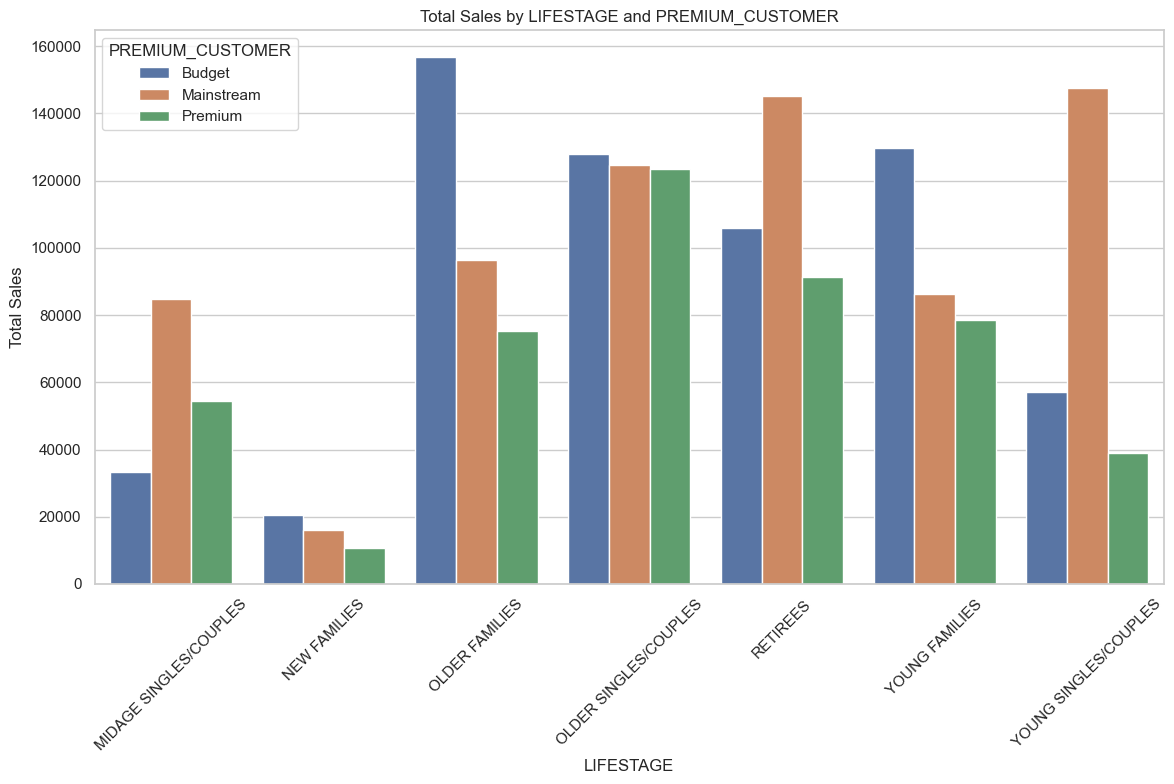


Number of Customers by Segment:
                 LIFESTAGE PREMIUM_CUSTOMER  Customer_Count
0   MIDAGE SINGLES/COUPLES           Budget            1474
1   MIDAGE SINGLES/COUPLES       Mainstream            3298
2   MIDAGE SINGLES/COUPLES          Premium            2369
3             NEW FAMILIES           Budget            1087
4             NEW FAMILIES       Mainstream             830
5             NEW FAMILIES          Premium             575
6           OLDER FAMILIES           Budget            4611
7           OLDER FAMILIES       Mainstream            2788
8           OLDER FAMILIES          Premium            2231
9    OLDER SINGLES/COUPLES           Budget            4849
10   OLDER SINGLES/COUPLES       Mainstream            4858
11   OLDER SINGLES/COUPLES          Premium            4682
12                RETIREES           Budget            4385
13                RETIREES       Mainstream            6358
14                RETIREES          Premium            3812
15     

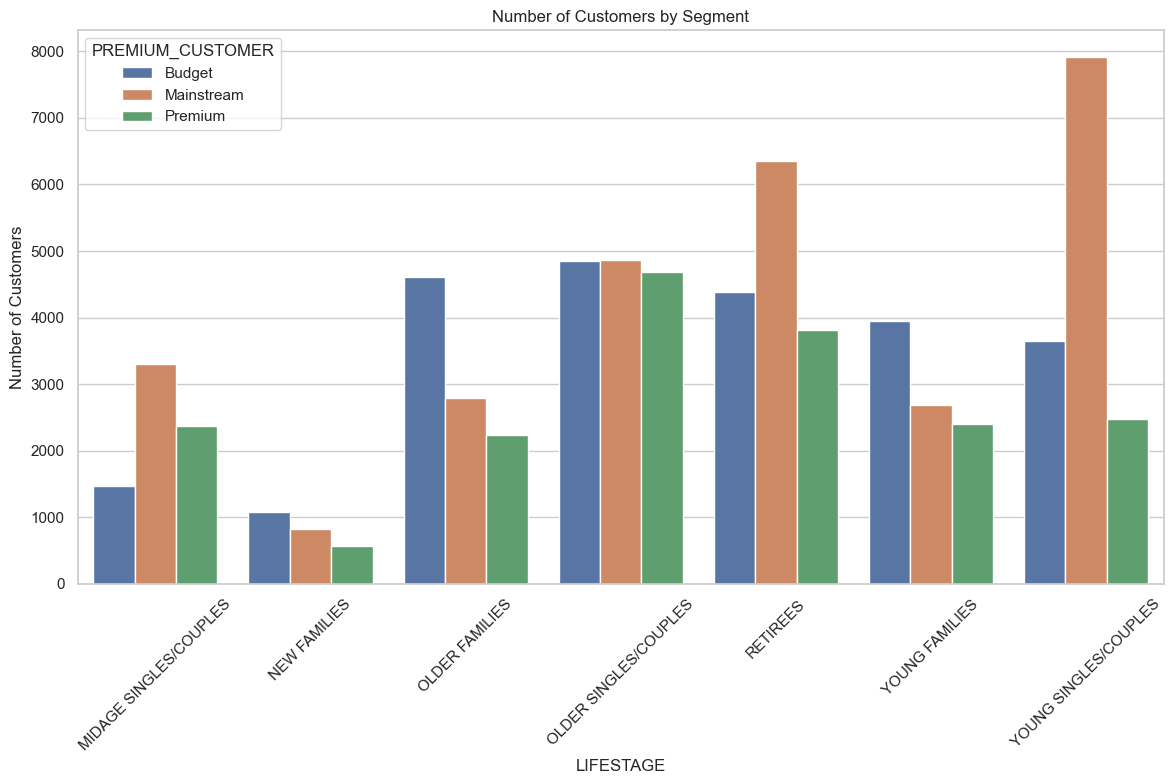


Average Units per Customer by Segment:
                 LIFESTAGE PREMIUM_CUSTOMER  Avg_Units
0   MIDAGE SINGLES/COUPLES           Budget   6.026459
1   MIDAGE SINGLES/COUPLES       Mainstream   6.432080
2   MIDAGE SINGLES/COUPLES          Premium   6.078514
3             NEW FAMILIES           Budget   4.821527
4             NEW FAMILIES       Mainstream   4.891566
5             NEW FAMILIES          Premium   4.815652
6           OLDER FAMILIES           Budget   9.076773
7           OLDER FAMILIES       Mainstream   9.255380
8           OLDER FAMILIES          Premium   9.071717
9    OLDER SINGLES/COUPLES           Budget   6.781398
10   OLDER SINGLES/COUPLES       Mainstream   6.712021
11   OLDER SINGLES/COUPLES          Premium   6.769543
12                RETIREES           Budget   6.141847
13                RETIREES       Mainstream   5.925920
14                RETIREES          Premium   6.103358
15          YOUNG FAMILIES           Budget   8.722995
16          YOUNG FAMILIE

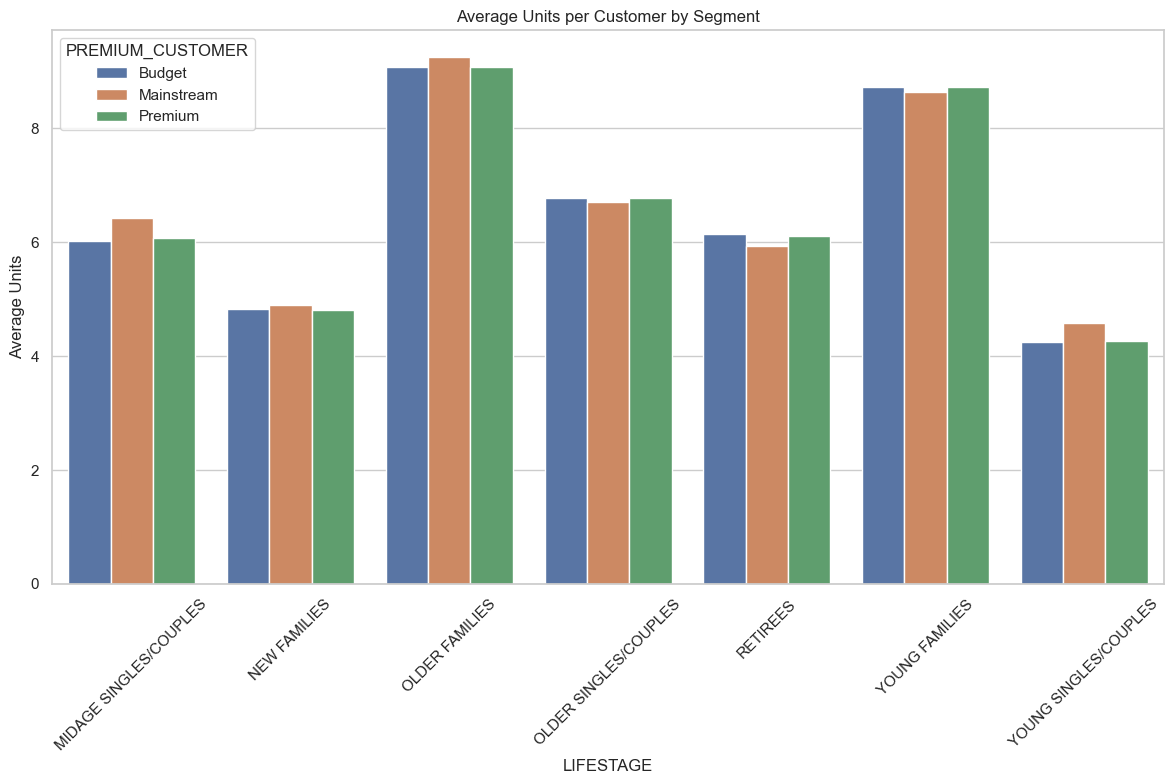


Average Price per Unit by Segment:
                 LIFESTAGE PREMIUM_CUSTOMER  Price_Per_Unit
0   MIDAGE SINGLES/COUPLES           Budget        3.743328
1   MIDAGE SINGLES/COUPLES       Mainstream        3.994241
2   MIDAGE SINGLES/COUPLES          Premium        3.770698
3             NEW FAMILIES           Budget        3.917688
4             NEW FAMILIES       Mainstream        3.916133
5             NEW FAMILIES          Premium        3.872110
6           OLDER FAMILIES           Budget        3.745340
7           OLDER FAMILIES       Mainstream        3.737077
8           OLDER FAMILIES          Premium        3.717000
9    OLDER SINGLES/COUPLES           Budget        3.882096
10   OLDER SINGLES/COUPLES       Mainstream        3.814665
11   OLDER SINGLES/COUPLES          Premium        3.893182
12                RETIREES           Budget        3.924404
13                RETIREES       Mainstream        3.844294
14                RETIREES          Premium        3.920942
15  

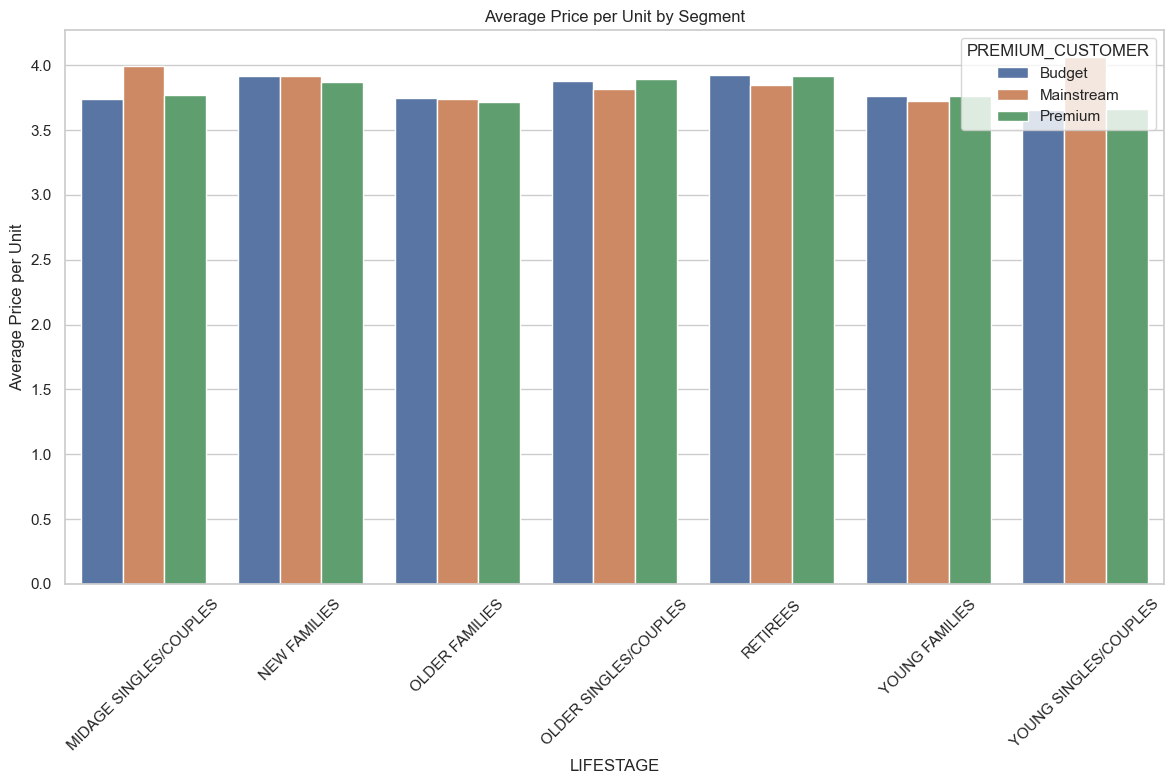


T-test for Price Per Unit (Mainstream vs Non-Mainstream):
t-statistic = 37.83196107667815 p-value = 1.11782280577468e-309


In [9]:
# Total Sales by LIFESTAGE and PREMIUM_CUSTOMER (using TOT_SALES)
sales = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
print("\nTotal Sales by LIFESTAGE and PREMIUM_CUSTOMER:")
print(sales)
plt.figure()
sns.barplot(x="LIFESTAGE", y="TOT_SALES", hue="PREMIUM_CUSTOMER", data=sales)
plt.title("Total Sales by LIFESTAGE and PREMIUM_CUSTOMER")
plt.xlabel("LIFESTAGE")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("total_sales_by_segment.png")
plt.show()
plt.close()

# Number of Customers by Segment
customer_counts = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index(name="Customer_Count")
print("\nNumber of Customers by Segment:")
print(customer_counts)
plt.figure()
sns.barplot(x="LIFESTAGE", y="Customer_Count", hue="PREMIUM_CUSTOMER", data=customer_counts)
plt.title("Number of Customers by Segment")
plt.xlabel("LIFESTAGE")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("customers_by_segment.png")
plt.show()
plt.close()

# Average Units per Customer by Segment (using PROD_QTY)
units_per_customer = data.groupby(['LYLTY_CARD_NBR', 'LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum().reset_index()
avg_units = units_per_customer.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].mean().reset_index(name="Avg_Units")
print("\nAverage Units per Customer by Segment:")
print(avg_units)
plt.figure()
sns.barplot(x="LIFESTAGE", y="Avg_Units", hue="PREMIUM_CUSTOMER", data=avg_units)
plt.title("Average Units per Customer by Segment")
plt.xlabel("LIFESTAGE")
plt.ylabel("Average Units")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("avg_units_by_segment.png")
plt.show()
plt.close()

# Average Price per Unit by Segment
data['Price_Per_Unit'] = data['TOT_SALES'] / data['PROD_QTY']
avg_price = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['Price_Per_Unit'].mean().reset_index()
print("\nAverage Price per Unit by Segment:")
print(avg_price)
plt.figure()
sns.barplot(x="LIFESTAGE", y="Price_Per_Unit", hue="PREMIUM_CUSTOMER", data=avg_price)
plt.title("Average Price per Unit by Segment")
plt.xlabel("LIFESTAGE")
plt.ylabel("Average Price per Unit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("avg_price_by_segment.png")
plt.show()
plt.close()

# Perform an independent t-test comparing Price_Per_Unit for Mainstream vs. Non-Mainstream 
# within YOUNG and MIDAGE SINGLES/COUPLES
group_mainstream = data[(data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
                        (data['PREMIUM_CUSTOMER'] == "Mainstream")]['Price_Per_Unit']
group_non_mainstream = data[(data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
                            (data['PREMIUM_CUSTOMER'] != "Mainstream")]['Price_Per_Unit']
t_stat, p_value = ttest_ind(group_mainstream, group_non_mainstream, nan_policy='omit', alternative='greater')
print("\nT-test for Price Per Unit (Mainstream vs Non-Mainstream):")
print("t-statistic =", t_stat, "p-value =", p_value)

# Deep Dive into Specific Customer Segments for Insights
Using a particular target customer segment to see its contribution to sales revenue


Target Segment Sample (YOUNG SINGLES/COUPLES - Mainstream):
             DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
221345 2018-08-16          1            1020      26        19   
221346 2018-08-17          1            1163     188        46   
221347 2018-08-14          1            1291     333        27   
221348 2019-05-15          3            3031    1227        14   
221349 2019-05-18          3            3118    1574        62   

                                     PROD_NAME  PROD_QTY  TOT_SALES  \
221345     Smiths Crinkle Cut  Snag&Sauce 150g         1        2.6   
221346                    Kettle Original 175g         1        5.4   
221347     WW Supreme Cheese   Corn Chips 200g         1        1.9   
221348  Smiths Crnkle Chip  Orgnl Big Bag 380g         1        5.9   
221349        Pringles Mystery    Flavour 134g         1        3.7   

        PACK_SIZE       BRAND              LIFESTAGE PREMIUM_CUSTOMER  \
221345      150.0      SMITHS  YOUNG SINGL

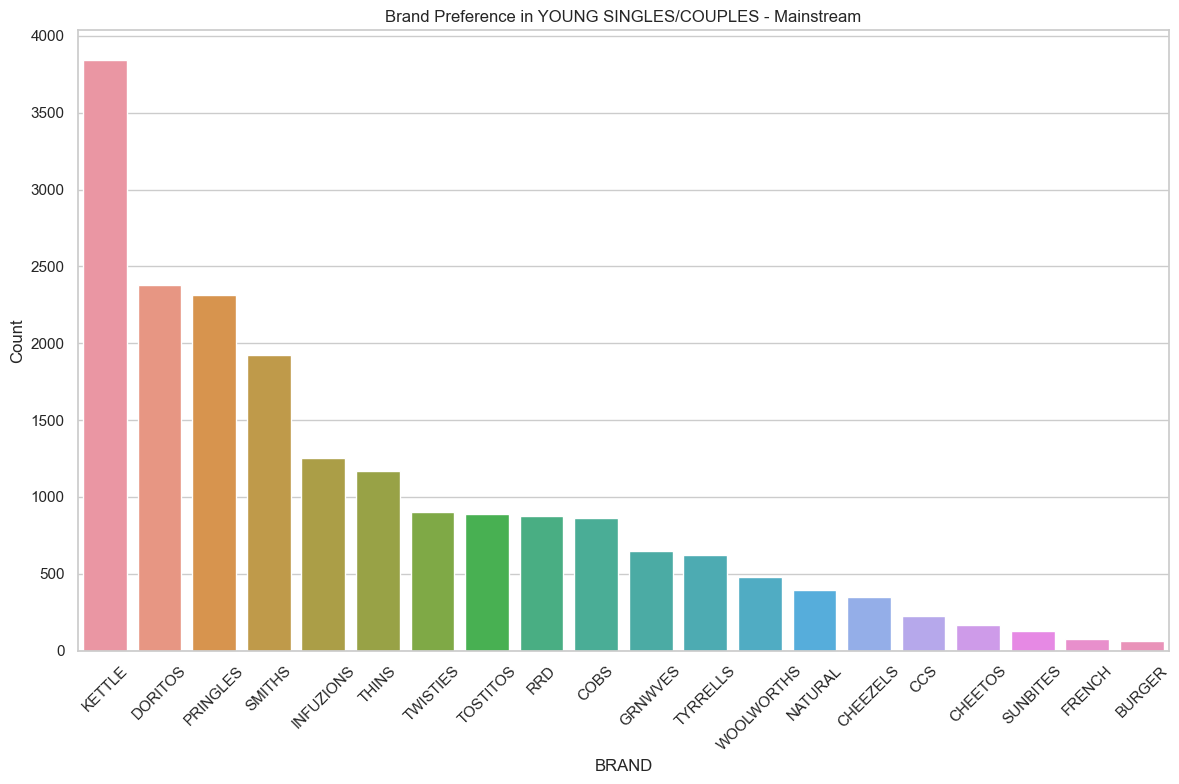


Pack Size Preference in YOUNG SINGLES/COUPLES - Mainstream:
    PACK_SIZE  Count
0       175.0   4997
1       150.0   3080
2       134.0   2315
3       110.0   2051
4       170.0   1575
5       330.0   1195
6       165.0   1102
7       380.0    626
8       270.0    620
9       210.0    576
10      135.0    290
11      250.0    280
12      200.0    179
13      190.0    148
14       90.0    128
15      160.0    128
16      180.0     70
17       70.0     63
18      220.0     62
19      125.0     59


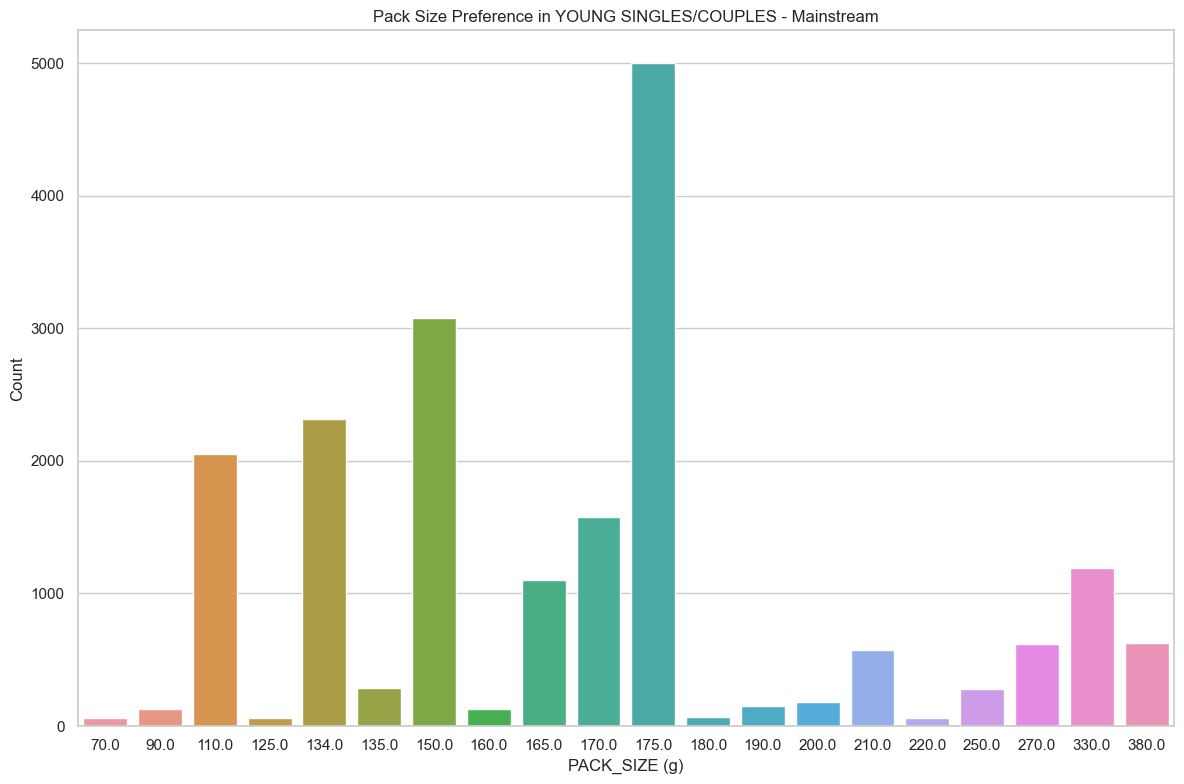

In [10]:
# Analyzing target segment "YOUNG SINGLES/COUPLES - Mainstream"
target_segment = data[(data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (data['PREMIUM_CUSTOMER'] == "Mainstream")]
print("\nTarget Segment Sample (YOUNG SINGLES/COUPLES - Mainstream):")
print(target_segment.head())

if target_segment.empty:
    print("No data available for target segment: YOUNG SINGLES/COUPLES - Mainstream.")
else:
    # Brand Preference Analysis within target segment
    brand_counts = target_segment['BRAND'].value_counts().reset_index()
    brand_counts.columns = ['BRAND', 'Count']
    print("\nBrand Preference in YOUNG SINGLES/COUPLES - Mainstream:")
    print(brand_counts)
    plt.figure()
    sns.barplot(x="BRAND", y="Count", data=brand_counts)
    plt.title("Brand Preference in YOUNG SINGLES/COUPLES - Mainstream")
    plt.xlabel("BRAND")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("brand_preference_target_segment.png")
    plt.show()
    plt.close()
    
    # Preferred Pack Size Analysis within target segment
    pack_size_counts = target_segment['PACK_SIZE'].value_counts().reset_index()
    pack_size_counts.columns = ['PACK_SIZE', 'Count']
    print("\nPack Size Preference in YOUNG SINGLES/COUPLES - Mainstream:")
    print(pack_size_counts)
    plt.figure()
    sns.barplot(x="PACK_SIZE", y="Count", data=pack_size_counts)
    plt.title("Pack Size Preference in YOUNG SINGLES/COUPLES - Mainstream")
    plt.xlabel("PACK_SIZE (g)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("pack_size_target_segment.png")
    plt.show()
    plt.close()

# Final Steps

In [11]:
print("\nAnalysis complete. The merged dataset is saved as 'QVI_data.csv' and all plots have been saved as PNG files.")


Analysis complete. The merged dataset is saved as 'QVI_data.csv' and all plots have been saved as PNG files.
